## Training Skip-Gram Model

This notebooks is a part of [AI for Beginners Curriculum](http://aka.ms/ai-beginners)

In this example, we will look at training CBoW language model to get our own Word2Vec embedding space. We will use AG News dataset as the source of text.

In [37]:
import torch
import torchtext
import os
import collections
import builtins
import random
import numpy as np

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

First let's load our dataset and define tokenizer and vocabulary. We will set `vocab_size` to 5000 to limit computations a bit.

In [39]:
def load_dataset(ngrams = 1, min_freq = 1, vocab_size = 5000 , lines_cnt = 500):
    tokenizer = torchtext.data.utils.get_tokenizer('basic_english')
    print("Loading dataset...")
    test_dataset, train_dataset  = torchtext.datasets.AG_NEWS(root='./data')
    train_dataset = list(train_dataset)
    test_dataset = list(test_dataset)
    classes = ['World', 'Sports', 'Business', 'Sci/Tech']
    print('Building vocab...')
    counter = collections.Counter()
    for i, (_, line) in enumerate(train_dataset):
        counter.update(torchtext.data.utils.ngrams_iterator(tokenizer(line),ngrams=ngrams))
        if i == lines_cnt:
            break
    vocab = torchtext.vocab.Vocab({k: i for i, k in enumerate(dict(counter.most_common(vocab_size)).keys())})
    return train_dataset, test_dataset, classes, vocab, tokenizer, counter

In [40]:
import torch.nn as nn
from typing import List

class Vocab(nn.Module):
    def __init__ (self, vocab_list):
        self.vocab = {k: i for i, k in enumerate(vocab_list)}
        self.vocab.update({'<unk>': len(self.vocab), '<pad>': len(self.vocab) + 1})
    
    def __len__(self):
        return len(self.vocab)
    
    def __getitem__(self, token: str) -> int:
        return self.vocab[token] if token in self.vocab.keys() else self.vocab['<unk>']
    
    def forward(self, tokens: List[str]) -> List[int]:
        return [self.vocab[token] for token in tokens]


In [41]:
train_dataset, test_dataset, _, vocab, tokenizer, counter = load_dataset()

Loading dataset...


Building vocab...


In [42]:
# Filter the counter to include only the top 5000 most common tokens
most_common_tokens = dict(counter.most_common(5000))

# Create the vocabulary
vocab = torchtext.vocab.Vocab(collections.Counter(most_common_tokens))

In [43]:
vocab
print(f"Vocabulary size: {len(vocab)}")

Vocabulary size: 5000


In [44]:
vocab = torchtext.vocab.Vocab(collections.Counter(dict(counter.most_common(5000))))

In [45]:
vocab

Vocab()

In [46]:
def encode(x, vocabulary, tokenizer = tokenizer):
    return [vocabulary[s] for s in tokenizer(x)]

In [47]:
{k: i for i, k in enumerate(dict(counter.most_common(5000)).keys())}

{'.': 0,
 'the': 1,
 ',': 2,
 'to': 3,
 'a': 4,
 'in': 5,
 'of': 6,
 's': 7,
 'and': 8,
 'on': 9,
 'for': 10,
 '(': 11,
 ')': 12,
 '-': 13,
 "'": 14,
 '#39': 15,
 'at': 16,
 'as': 17,
 'reuters': 18,
 'that': 19,
 'ap': 20,
 'it': 21,
 'with': 22,
 'new': 23,
 'its': 24,
 'said': 25,
 'by': 26,
 'is': 27,
 'has': 28,
 'from': 29,
 'an': 30,
 'after': 31,
 'his': 32,
 'will': 33,
 'have': 34,
 'but': 35,
 'athens': 36,
 'u': 37,
 'olympic': 38,
 '--': 39,
 'he': 40,
 'gold': 41,
 'monday': 42,
 'us': 43,
 'their': 44,
 'was': 45,
 'oil': 46,
 'over': 47,
 'up': 48,
 'more': 49,
 'are': 50,
 'first': 51,
 'tuesday': 52,
 'be': 53,
 'wednesday': 54,
 'they': 55,
 'prices': 56,
 'two': 57,
 'who': 58,
 '&lt': 59,
 'into': 60,
 'inc': 61,
 'sunday': 62,
 'china': 63,
 'afp': 64,
 'team': 65,
 'one': 66,
 'quot': 67,
 'were': 68,
 'out': 69,
 'off': 70,
 'about': 71,
 'can': 72,
 'would': 73,
 'medal': 74,
 'night': 75,
 'president': 76,
 'not': 77,
 'united': 78,
 'win': 79,
 't': 80,
 'yor

In [48]:
vocab.vocab

Counter({'.': 1126,
         'the': 944,
         ',': 714,
         'to': 530,
         'a': 490,
         'in': 444,
         'of': 443,
         's': 295,
         'and': 277,
         'on': 249,
         'for': 228,
         '(': 226,
         ')': 225,
         '-': 223,
         "'": 190,
         '#39': 156,
         'at': 117,
         'as': 110,
         'reuters': 108,
         'that': 106,
         'ap': 100,
         'it': 98,
         'with': 96,
         'new': 91,
         'its': 89,
         'said': 89,
         'by': 80,
         'is': 73,
         'has': 73,
         'from': 72,
         'an': 70,
         'after': 64,
         'his': 64,
         'will': 61,
         'have': 61,
         'but': 56,
         'athens': 54,
         'u': 52,
         'olympic': 50,
         '--': 49,
         'he': 49,
         'gold': 47,
         'monday': 47,
         'us': 46,
         'their': 45,
         'was': 45,
         'oil': 44,
         'over': 42,
         'up': 41,
     

## Skip-Gram Model

Skip-Gram learns to predict neighboring words based on a given center word. For example, when \(N=1\), we will get the following pairs from the sentence *I like to train networks*: (I, like), (I, to), (like, I), (like, to), (like, train), (to, like), (to, train), (to, networks), (train, to), (train, networks). Here, the first word is the **center word** used as input, and the second word is a **neighboring word** we aim to predict.

To build a network to predict context words, we supply the **center word** as input and predict **neighboring words** as output. The architecture of the Skip-Gram network is as follows:

*  The **input center word** is passed through an embedding layer. This embedding layer will represent our Word2Vec embeddings, and we define it separately as the `embedder` variable. We use an embedding size of 30 in this example, but real Word2Vec models often use 300.
* The embedding vector is then passed to a linear layer, which predicts output word probabilities over the entire vocabulary. The linear layer has `vocab_size` output neurons.


For the output, if we use `CrossEntropyLoss` as loss function, we would also have to provide just word numbers as expected results, without one-hot encoding.

In [69]:
# Define the Skip-Gram model
vocab_size = len(vocab)
embedding_dim = 30

embedder = torch.nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
model = torch.nn.Sequential(
    embedder,  # Embedding layer
    torch.nn.Linear(in_features=embedding_dim, out_features=vocab_size)  # Output layer
)

print(model)
# Output:
# Sequential(
#   (0): Embedding(vocab_size, 30)
#   (1): Linear(30, vocab_size, bias=True)
# )

Sequential(
  (0): Embedding(5000, 30)
  (1): Linear(in_features=30, out_features=5000, bias=True)
)


## Preparing Training Data

Now let's program the main function that computes Skip-Gram word pairs from text. This function will allow us to specify the window size and will return a set of pairs where the **input is the center word** and the **output is a neighboring context word**. Note that this function can process both tokenized words and encoded tensors (e.g., converted using the vocabulary).

In [50]:
def to_skipgram(sentence, window_size=2):
    """Generates Skip-Gram pairs from a tokenized sentence."""
    skipgram_pairs = []
    for center_idx, center_word in enumerate(sentence):
        # Determine the context window boundaries
        start_idx = max(center_idx - window_size, 0)
        end_idx = min(center_idx + window_size + 1, len(sentence))
        
        # Create pairs for the center word and each context word
        for context_idx in range(start_idx, end_idx):
            if context_idx != center_idx:  # Exclude the center word itself
                skipgram_pairs.append((center_word, sentence[context_idx]))
    return skipgram_pairs

print(to_skipgram(['I','like','to','train','networks']))
print(to_skipgram(encode('I like to train networks', vocab)))

[('I', 'like'), ('I', 'to'), ('like', 'I'), ('like', 'to'), ('like', 'train'), ('to', 'I'), ('to', 'like'), ('to', 'train'), ('to', 'networks'), ('train', 'like'), ('train', 'to'), ('train', 'networks'), ('networks', 'to'), ('networks', 'train')]
[(14, 11), (14, 530), (11, 14), (11, 530), (11, 0), (530, 14), (530, 11), (530, 0), (530, 3), (0, 11), (0, 530), (0, 3), (3, 530), (3, 0)]


In [51]:
to_skipgram(['I','like','to','train','networks'], window_size=2)

[('I', 'like'),
 ('I', 'to'),
 ('like', 'I'),
 ('like', 'to'),
 ('like', 'train'),
 ('to', 'I'),
 ('to', 'like'),
 ('to', 'train'),
 ('to', 'networks'),
 ('train', 'like'),
 ('train', 'to'),
 ('train', 'networks'),
 ('networks', 'to'),
 ('networks', 'train')]

In [52]:
encode('I like to train networks', vocab)

[14, 11, 530, 0, 3]

Let's prepare the training dataset. We will iterate through all news items, call `to_skipgram` to generate Skip-Gram pairs, and add these pairs to `X` (inputs) and `Y` (outputs). For the sake of time, we will only consider the first 10k news items. You can remove this limitation if you want better embeddings and have more time to train.

In [53]:
X = []
Y = []
for i, x in zip(range(10000), train_dataset):
    for center, context in to_skipgram(encode(x[1], vocab), window_size=5):
        X.append(center)  # Center word as input
        Y.append(context)  # Context word as label

X = torch.tensor(X)
Y = torch.tensor(Y)

We will also convert that data to one dataset, and create dataloader:

In [54]:
class SimpleIterableDataset(torch.utils.data.IterableDataset):
    def __init__(self, X, Y):
        super(SimpleIterableDataset).__init__()
        self.data = []
        for i in range(len(X)):
            self.data.append( (Y[i], X[i]) )
        random.shuffle(self.data)

    def __iter__(self):
        return iter(self.data)

We will also convert that data to one dataset, and create dataloader:

In [55]:
ds = SimpleIterableDataset(X, Y)
dl = torch.utils.data.DataLoader(ds, batch_size = 256)

Now let's do the actual training. We will use `SGD` optimizer with pretty high learning rate. You can also try playing around with other optimizers, such as `Adam`. We will train for 10 epochs to begin with - and you can re-run this cell if you want even lower loss.

In [56]:
import torch

def train_epoch(net, dataloader, optimizer, loss_fn, epochs, device=device, report_freq=1):
    # Move model to the specified device (GPU or CPU)
    net = net.to(device)
    loss_fn = loss_fn.to(device)  # Ensure the loss function is also on the same device
    net.train()

    for epoch in range(epochs):
        total_loss = 0.0
        batch_count = 0

        for labels, features in dataloader:
            # Move data to the specified device
            features, labels = features.to(device), labels.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = net(features)

            # Calculate loss
            loss = loss_fn(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate loss
            total_loss += loss.item()
            batch_count += 1

        # Report average loss for the epoch
        if epoch % report_freq == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {total_loss / batch_count:.4f}")

    return total_loss / batch_count

In [57]:
train_epoch(net = model, dataloader = dl, optimizer = torch.optim.SGD(model.parameters(), lr = 0.1), loss_fn = torch.nn.CrossEntropyLoss(), epochs = 10)

Epoch [1/10], Loss: 3.9115
Epoch [2/10], Loss: 3.6154
Epoch [3/10], Loss: 3.6076
Epoch [4/10], Loss: 3.6048
Epoch [5/10], Loss: 3.6033
Epoch [6/10], Loss: 3.6023
Epoch [7/10], Loss: 3.6016
Epoch [8/10], Loss: 3.6010
Epoch [9/10], Loss: 3.6005
Epoch [10/10], Loss: 3.6001


3.600117825968346

## Trying out Word2Vec

To use Word2Vec, let's extract vectors corresponding to all words in our vocabulary:

In [58]:
from torchtext.vocab import vocab as Vocab
from collections import Counter

# Assuming `counter` is your word frequency counter
# Create a vocabulary from the counter
most_common_tokens = Counter(dict(counter.most_common(5000)))
vocab = Vocab(most_common_tokens)

Analyze the Embeddings

In [59]:
tokens = vocab.get_itos()

In [60]:
vectors = torch.stack(
    [embedder(torch.tensor(vocab[token]).to(device)) for token in tokens], dim=0
)

### Using PCA for Word Embedding Visualization

This section demonstrates how to visualize high-dimensional word embeddings (e.g., 30 or 300 dimensions) in a 2D space using **Principal Component Analysis (PCA)**. PCA reduces the dimensionality of the embeddings while retaining the most significant patterns in the data, enabling visualization.

#### Steps:
1. **Dimensionality Reduction**: We use `sklearn.decomposition.PCA` to reduce the embeddings to 2 dimensions, suitable for visualization.
2. **Word Selection**: A few representative words are selected, and their embeddings are extracted from the trained model.
3. **Visualization**: We use `matplotlib.pyplot` to plot the 2D points, where each point represents a word's embedding. Similar words appear closer together.

#### Code Explanation:
- `PCA(n_components=2)` initializes the PCA transformation with 2 components for 2D output.
- `fit_transform` computes the principal components and reduces the dimensions of the embeddings.
- `plt.scatter` and `plt.text` are used to plot the reduced embeddings and label them with their respective words.

#### Visualization Insights:
The resulting scatter plot shows how the Skip-Gram model clusters semantically related words closer together in the embedding space. For example, synonyms like "king" and "queen" or contextually similar words like "man" and "woman" often appear near each other.

Valid tokens: ['man', 'woman', 'child', 'money', 'bank']


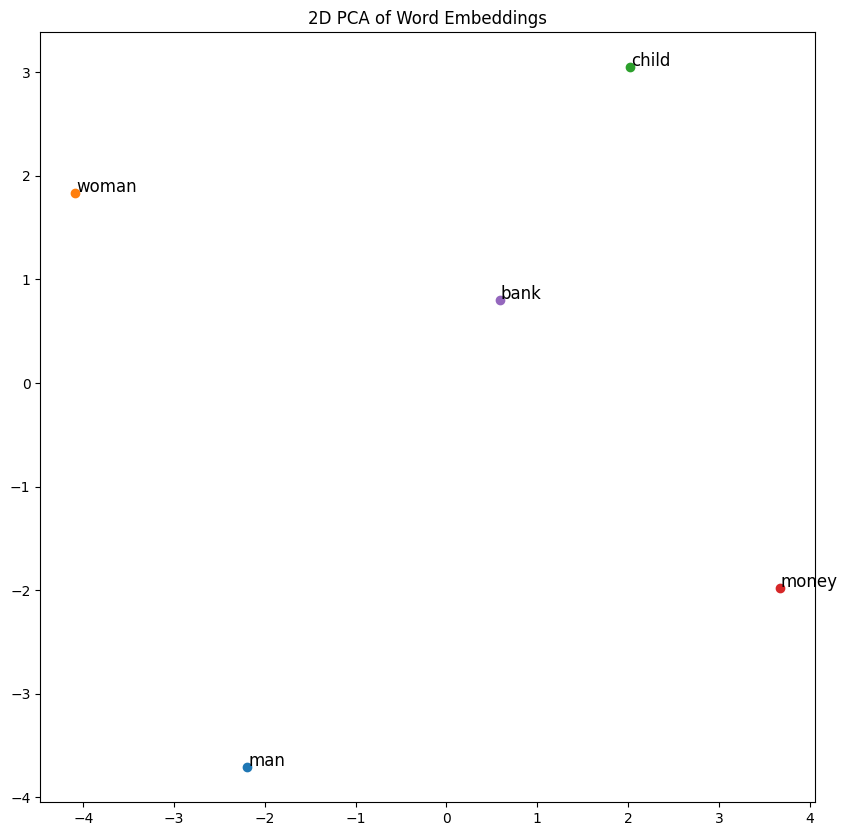

In [61]:
# Assuming vectors and vocab are already defined
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Step 1: Tokenize and preprocess words
words = ['king', 'queen', 'man', 'woman', 'child', 'money', 'bank']
tokens = [tokenizer(word.lower()) for word in words]
tokens = [token[0] if len(token) > 0 else '' for token in tokens]

# Step 2: Check for missing tokens
valid_tokens = [token for token in tokens if token in vocab]
if not valid_tokens:
    print("No valid tokens found in vocab.")
else:
    print(f"Valid tokens: {valid_tokens}")

# Step 3: Retrieve valid embeddings
valid_indices = [vocab[token] for token in valid_tokens]
valid_vectors = vectors[valid_indices]

# Step 4: PCA and visualization
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(valid_vectors.detach().cpu().numpy())

plt.figure(figsize=(10, 10))
for word, coord in zip(valid_tokens, reduced_vectors):
    plt.scatter(coord[0], coord[1], marker='o')
    plt.text(coord[0] + 0.01, coord[1] + 0.01, word, fontsize=12)
plt.title('2D PCA of Word Embeddings')
plt.show()

Let's see, for example, how the word **Paris** is encoded into a vector:

In [62]:
paris_vec = embedder(torch.tensor(vocab['paris']).to(device))
print(paris_vec)

tensor([ 0.6908, -0.2282, -0.7292, -0.0598,  0.1222,  1.9627, -1.3863, -0.7670,
         0.5945, -2.2696, -0.6248,  0.0191,  0.4180, -1.3327, -0.3266,  0.2169,
         0.5590,  0.0631,  2.2782,  0.5275, -1.3107, -0.2342, -1.0921, -0.1565,
         0.0703,  0.0226, -2.0698, -1.0678, -0.2925, -0.0646], device='cuda:0',
       grad_fn=<EmbeddingBackward0>)


It is interesting to use Word2Vec to look for synonyms. The following function will return `n` closest words to a given input. To find them, we compute the norm of $|w_i - v|$, where $v$ is the vector corresponding to our input word, and $w_i$ is the encoding of $i$-th word in the vocabulary. We then sort the array and return corresponding indices using `argsort`, and take first `n` elements of the list, which encode positions of closest words in the vocabulary.  

In [63]:
def close_words(x, n=5):
    # Ensure all computations are performed on the same device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Move vectors to the correct device
    vec = embedder(torch.tensor(vocab[x]).to(device))
    vectors_on_device = vectors.to(device)
    
    # Compute distances and find closest words
    top5 = np.linalg.norm(
        vectors_on_device.detach().cpu().numpy() - vec.detach().cpu().numpy(),
        axis=1
    ).argsort()[:n]
    
    # Map indices to tokens using the appropriate method
    try:
        tokens = vocab.get_itos()  # Use for modern versions
    except AttributeError:
        tokens = vocab.itos  # Use for older versions
    
    # Return the closest tokens
    return [tokens[x] for x in top5]

In [64]:
close_words('basketball')

['basketball', 'diva', 'while', 'mail-order', 'measures']

In [65]:
close_words('funds')

['funds', 'working-level', 'corp', 'abuse', 'anti-semitic']

king not in token

In [66]:
def close_words(x, n=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Preprocess the input token
    x = x.lower()  # Ensure lowercase if vocab uses it
    if x not in vocab:
        print(f"Token '{x}' not found in vocabulary. Using '<unk>' instead.")
        x = '<unk>'

    # Get the embedding for the input token
    vec = embedder(torch.tensor(vocab[x]).to(device))

    # Compute distances
    vectors_on_device = vectors.to(device)
    distances = np.linalg.norm(
        vectors_on_device.detach().cpu().numpy() - vec.detach().cpu().numpy(),
        axis=1
    )

    # Find closest words
    top_indices = distances.argsort()[:n]
    tokens = vocab.get_itos()  # Get the index-to-string mapping
    return [tokens[i] for i in top_indices]

In [67]:
print(close_words('king'))

Token 'king' not found in vocabulary. Using '<unk>' instead.


RuntimeError: Token <unk> not found and default index is not set

## Takeaway

Using clever techniques such as CBoW, we can train Word2Vec model. You may also try to train skip-gram model that is trained to predict the neighboring word given the central one, and see how well it performs. 